In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL
from PIL import Image
import os
from tqdm import tqdm
import gc
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix

from torchvision import transforms
import timm
from collections import Counter

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d amanrawat001/celeb-df-preprocessed

Dataset URL: https://www.kaggle.com/datasets/amanrawat001/celeb-df-preprocessed
License(s): CC0-1.0
 98% 294M/300M [00:00<00:00, 857MB/s] 
100% 300M/300M [00:00<00:00, 898MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("/content/celeb-df-preprocessed.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [6]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
data_path = "/content/Celeb-DF Preprocessed"

In [7]:
device

'cuda'

# Dataset

In [8]:

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.image_paths)


In [9]:
'''
class ImageDataset(Dataset):

    def __init__(self, image_paths, labels, transform=None, cache=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.cache = cache
        self.cached_images = [None] * len(image_paths)


    def __getitem__(self, idx):
        if self.cache and self.cached_images[idx] is not None:
            image = self.cached_images[idx]
        else:
            image_path = self.image_paths[idx]
            label = self.labels[idx]

            try:
                image = Image.open(image_path).convert("RGB")
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                image = Image.new("RGB", (224, 224), (0, 0, 0))

            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            if self.cache:
                self.cached_images[idx] = image

        return image, torch.tensor(self.labels[idx], dtype=torch.long)


    def __len__(self):
        return len(self.image_paths)
        '''


'\nclass ImageDataset(Dataset):\n\n    def __init__(self, image_paths, labels, transform=None, cache=True):\n        self.image_paths = image_paths\n        self.labels = labels\n        self.transform = transform\n        self.cache = cache\n        self.cached_images = [None] * len(image_paths)\n\n\n    def __getitem__(self, idx):\n        if self.cache and self.cached_images[idx] is not None:\n            image = self.cached_images[idx]\n        else:\n            image_path = self.image_paths[idx]\n            label = self.labels[idx]\n\n            try:\n                image = Image.open(image_path).convert("RGB")\n            except Exception as e:\n                print(f"Error loading {image_path}: {e}")\n                image = Image.new("RGB", (224, 224), (0, 0, 0))\n\n            if self.transform:\n                image = self.transform(image)\n            else:\n                image = transforms.ToTensor()(image)\n\n            if self.cache:\n                self.cached

In [10]:
def load_image_dataset(base_path):
    image_paths = []
    labels = []

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue

        for label_type in ['real', 'fake']:
            label_path = os.path.join(split_path, label_type)
            if not os.path.exists(label_path):
                continue

            label_value = 0 if label_type == 'real' else 1

            for img_file in os.listdir(label_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, img_file))
                    labels.append(label_value)

    return image_paths, labels

In [11]:
def load_split_dataset(base_path, split):
    """Load specific split (train/val/test)"""
    image_paths = []
    labels = []

    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        return [], []

    for label_type in ['real', 'fake']:
        label_path = os.path.join(split_path, label_type)
        if not os.path.exists(label_path):
            continue

        label_value = 0 if label_type == 'real' else 1

        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label_value)

    return image_paths, labels

# Model - EfficientNet b3

In [12]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b3', num_classes=2, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Train and Validation Functions

In [13]:
def train_model_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    train_tqdm = tqdm(train_loader, desc="Training")

    for images, labels in train_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        all_preds.extend(predicted.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

        train_tqdm.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="binary")
    precision = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0

    return avg_loss, accuracy, f1, precision, recall, auc, all_probs

In [14]:
def validate_model(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        val_tqdm = tqdm(val_loader, desc="Validation")

        for images, labels in val_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())


    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    precision = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    return avg_loss, accuracy, f1, precision, recall, auc, all_probs, all_labels

Using device: cuda
Train samples: 45766
Val samples: 13075
Test samples: 6540
Train label distribution: Counter({1: 34865, 0: 10901})
Val label distribution: Counter({1: 9961, 0: 3114})
Test label distribution: Counter({1: 4982, 0: 1558})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Training: EfficientNetClassifier
--------------------------------------------------

Epoch 1/15


Validation: 100%|██████████| 409/409 [00:33<00:00, 12.09it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.73      0.83      3114
        Fake       0.92      0.99      0.96      9961

    accuracy                           0.93     13075
   macro avg       0.95      0.86      0.89     13075
weighted avg       0.93      0.93      0.93     13075


Train Metrics:
  Loss: 0.2738 | Acc: 0.8878 | F1: 0.9293
  Prec: 0.8931 | Rec: 0.9686 | AUC: 0.9241

Val Metrics:
  Loss: 0.1694 | Acc: 0.9309 | F1: 0.9564
  Prec: 0.9210 | Rec: 0.9946 | AUC: 0.9702
  --> Best model saved!

Epoch 2/15


Validation: 100%|██████████| 409/409 [00:33<00:00, 12.32it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.82      0.88      3114
        Fake       0.95      0.99      0.97      9961

    accuracy                           0.95     13075
   macro avg       0.95      0.90      0.92     13075
weighted avg       0.95      0.95      0.95     13075


Train Metrics:
  Loss: 0.1736 | Acc: 0.9320 | F1: 0.9565
  Prec: 0.9341 | Rec: 0.9800 | AUC: 0.9700

Val Metrics:
  Loss: 0.1390 | Acc: 0.9482 | F1: 0.9668
  Prec: 0.9463 | Rec: 0.9881 | AUC: 0.9785
  --> Best model saved!

Epoch 3/15


Validation: 100%|██████████| 409/409 [00:34<00:00, 11.84it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.85      0.89      3114
        Fake       0.95      0.98      0.97      9961

    accuracy                           0.95     13075
   macro avg       0.95      0.92      0.93     13075
weighted avg       0.95      0.95      0.95     13075


Train Metrics:
  Loss: 0.1445 | Acc: 0.9450 | F1: 0.9646
  Prec: 0.9466 | Rec: 0.9833 | AUC: 0.9791

Val Metrics:
  Loss: 0.1282 | Acc: 0.9513 | F1: 0.9685
  Prec: 0.9535 | Rec: 0.9840 | AUC: 0.9824
  --> Best model saved!

Epoch 4/15


Validation: 100%|██████████| 409/409 [00:34<00:00, 11.78it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.84      0.90      3114
        Fake       0.95      0.99      0.97      9961

    accuracy                           0.95     13075
   macro avg       0.96      0.91      0.93     13075
weighted avg       0.96      0.95      0.95     13075


Train Metrics:
  Loss: 0.1247 | Acc: 0.9533 | F1: 0.9698
  Prec: 0.9536 | Rec: 0.9867 | AUC: 0.9837

Val Metrics:
  Loss: 0.1249 | Acc: 0.9549 | F1: 0.9710
  Prec: 0.9511 | Rec: 0.9918 | AUC: 0.9830
  --> Best model saved!

Epoch 5/15


Validation: 100%|██████████| 409/409 [00:33<00:00, 12.09it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.86      0.91      3114
        Fake       0.96      0.99      0.97      9961

    accuracy                           0.96     13075
   macro avg       0.96      0.92      0.94     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.1081 | Acc: 0.9606 | F1: 0.9746
  Prec: 0.9595 | Rec: 0.9901 | AUC: 0.9873

Val Metrics:
  Loss: 0.1188 | Acc: 0.9600 | F1: 0.9742
  Prec: 0.9568 | Rec: 0.9923 | AUC: 0.9851
  --> Best model saved!

Epoch 6/15


Validation: 100%|██████████| 409/409 [00:30<00:00, 13.24it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.88      0.91      3114
        Fake       0.96      0.98      0.97      9961

    accuracy                           0.96     13075
   macro avg       0.95      0.93      0.94     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.0983 | Acc: 0.9645 | F1: 0.9770
  Prec: 0.9630 | Rec: 0.9915 | AUC: 0.9896

Val Metrics:
  Loss: 0.1230 | Acc: 0.9579 | F1: 0.9727
  Prec: 0.9631 | Rec: 0.9824 | AUC: 0.9852

Epoch 7/15


Validation: 100%|██████████| 409/409 [00:33<00:00, 12.05it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.87      0.92      3114
        Fake       0.96      0.99      0.98      9961

    accuracy                           0.97     13075
   macro avg       0.97      0.93      0.95     13075
weighted avg       0.97      0.97      0.97     13075


Train Metrics:
  Loss: 0.0880 | Acc: 0.9686 | F1: 0.9797
  Prec: 0.9660 | Rec: 0.9938 | AUC: 0.9910

Val Metrics:
  Loss: 0.1015 | Acc: 0.9658 | F1: 0.9779
  Prec: 0.9618 | Rec: 0.9946 | AUC: 0.9881
  --> Best model saved!

Epoch 8/15


Validation: 100%|██████████| 409/409 [00:31<00:00, 12.84it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.88      0.92      3114
        Fake       0.96      0.99      0.98      9961

    accuracy                           0.97     13075
   macro avg       0.97      0.94      0.95     13075
weighted avg       0.97      0.97      0.97     13075


Train Metrics:
  Loss: 0.0803 | Acc: 0.9715 | F1: 0.9816
  Prec: 0.9689 | Rec: 0.9946 | AUC: 0.9924

Val Metrics:
  Loss: 0.1081 | Acc: 0.9656 | F1: 0.9777
  Prec: 0.9644 | Rec: 0.9915 | AUC: 0.9871

Epoch 9/15


Validation: 100%|██████████| 409/409 [00:31<00:00, 12.97it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.88      0.93      3114
        Fake       0.96      0.99      0.98      9961

    accuracy                           0.97     13075
   macro avg       0.97      0.94      0.95     13075
weighted avg       0.97      0.97      0.97     13075


Train Metrics:
  Loss: 0.0759 | Acc: 0.9732 | F1: 0.9826
  Prec: 0.9703 | Rec: 0.9953 | AUC: 0.9932

Val Metrics:
  Loss: 0.1070 | Acc: 0.9662 | F1: 0.9781
  Prec: 0.9647 | Rec: 0.9919 | AUC: 0.9876
  --> Best model saved!

Epoch 10/15


Validation: 100%|██████████| 409/409 [00:30<00:00, 13.23it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.89      0.93      3114
        Fake       0.97      0.99      0.98      9961

    accuracy                           0.97     13075
   macro avg       0.97      0.94      0.95     13075
weighted avg       0.97      0.97      0.97     13075


Train Metrics:
  Loss: 0.0706 | Acc: 0.9746 | F1: 0.9835
  Prec: 0.9715 | Rec: 0.9959 | AUC: 0.9940

Val Metrics:
  Loss: 0.1080 | Acc: 0.9671 | F1: 0.9787
  Prec: 0.9652 | Rec: 0.9927 | AUC: 0.9876
  --> Best model saved!

Epoch 11/15


Validation: 100%|██████████| 409/409 [00:31<00:00, 12.80it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.87      0.91      3114
        Fake       0.96      0.99      0.97      9961

    accuracy                           0.96     13075
   macro avg       0.96      0.93      0.94     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.1031 | Acc: 0.9633 | F1: 0.9763
  Prec: 0.9635 | Rec: 0.9894 | AUC: 0.9890

Val Metrics:
  Loss: 0.1253 | Acc: 0.9599 | F1: 0.9741
  Prec: 0.9607 | Rec: 0.9879 | AUC: 0.9849

Epoch 12/15


Validation: 100%|██████████| 409/409 [00:31<00:00, 12.93it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.88      0.91      3114
        Fake       0.96      0.98      0.97      9961

    accuracy                           0.96     13075
   macro avg       0.95      0.93      0.94     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.1013 | Acc: 0.9639 | F1: 0.9766
  Prec: 0.9636 | Rec: 0.9901 | AUC: 0.9892

Val Metrics:
  Loss: 0.1356 | Acc: 0.9573 | F1: 0.9723
  Prec: 0.9631 | Rec: 0.9816 | AUC: 0.9841

Epoch 13/15


Validation: 100%|██████████| 409/409 [00:30<00:00, 13.21it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.87      0.92      3114
        Fake       0.96      0.99      0.98      9961

    accuracy                           0.96     13075
   macro avg       0.97      0.93      0.95     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.0950 | Acc: 0.9671 | F1: 0.9787
  Prec: 0.9662 | Rec: 0.9915 | AUC: 0.9903

Val Metrics:
  Loss: 0.1137 | Acc: 0.9628 | F1: 0.9760
  Prec: 0.9612 | Rec: 0.9913 | AUC: 0.9860

Epoch 14/15


Validation: 100%|██████████| 409/409 [00:31<00:00, 13.08it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.88      0.92      3114
        Fake       0.96      0.99      0.98      9961

    accuracy                           0.96     13075
   macro avg       0.96      0.93      0.95     13075
weighted avg       0.96      0.96      0.96     13075


Train Metrics:
  Loss: 0.0929 | Acc: 0.9676 | F1: 0.9790
  Prec: 0.9672 | Rec: 0.9911 | AUC: 0.9909

Val Metrics:
  Loss: 0.1099 | Acc: 0.9636 | F1: 0.9764
  Prec: 0.9629 | Rec: 0.9904 | AUC: 0.9870

Early stopping triggered after 14 epochs
FINAL TESTING


Validation: 100%|██████████| 205/205 [00:16<00:00, 12.75it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.88      0.93      1558
        Fake       0.96      0.99      0.98      4982

    accuracy                           0.97      6540
   macro avg       0.97      0.94      0.95      6540
weighted avg       0.97      0.97      0.97      6540


==================== FINAL RESULTS ====================
Test Accuracy:  0.9667
Test F1 Score:  0.9784
Test Precision: 0.9640
Test Recall:    0.9934
Test ROC AUC:   0.9866
Test Loss:      0.1168


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/confusion_matrix.png'

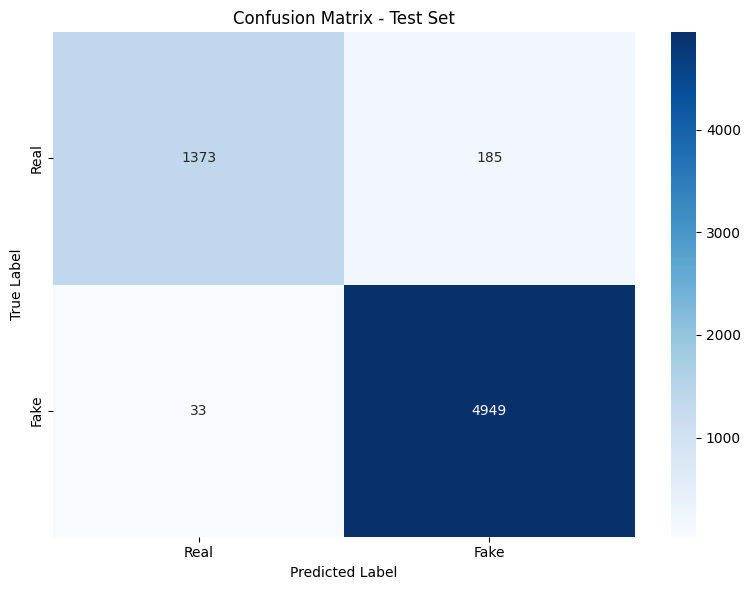

In [15]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_paths, train_labels = load_split_dataset(data_path, 'train')
    val_paths, val_labels = load_split_dataset(data_path, 'val')
    test_paths, test_labels = load_split_dataset(data_path, 'test')

    print(f"Train samples: {len(train_paths)}")
    print(f"Val samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")
    print(f"Train label distribution: {Counter(train_labels)}")
    print(f"Val label distribution: {Counter(val_labels)}")
    print(f"Test label distribution: {Counter(test_labels)}")

    train_dataset = ImageDataset(train_paths, train_labels, train_transform)
    val_dataset = ImageDataset(val_paths, val_labels, val_transform)
    test_dataset = ImageDataset(test_paths, test_labels, val_transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

    model = EfficientNetClassifier('efficientnet_b0', num_classes=2)

    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 15
    best_val_f1 = 0
    patience = 4
    counter = 0

    print(f"\nTraining: {model.__class__.__name__}")
    print("-" * 50)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_acc, train_f1, train_prec, train_rec, train_auc, _ = train_model_one_epoch(
            model, train_loader, optimizer, loss_fn, device
        )

        val_loss, val_acc, val_f1, val_prec, val_rec, val_auc, _, _ = validate_model(
            model, val_loader, loss_fn, device
        )

        scheduler.step()

        print(f"\nTrain Metrics:")
        print(f"  Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
        print(f"  Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | AUC: {train_auc:.4f}")

        print(f"\nVal Metrics:")
        print(f"  Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
        print(f"  Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | AUC: {val_auc:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "/content/EfficientNet.pth")
            counter = 0
            print("  --> Best model saved!")
        else:
            counter += 1

        if counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        torch.cuda.empty_cache()
        gc.collect()

    print("FINAL TESTING")
    print("="*60)

    model.load_state_dict(torch.load("/content/EfficientNet.pth"))

    test_loss, test_acc, test_f1, test_prec, test_rec, test_auc, test_probs, test_true = validate_model(
        model, test_loader, loss_fn, device
    )

    print(f"\n{'='*20} FINAL RESULTS {'='*20}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test F1 Score:  {test_f1:.4f}")
    print(f"Test Precision: {test_prec:.4f}")
    print(f"Test Recall:    {test_rec:.4f}")
    print(f"Test ROC AUC:   {test_auc:.4f}")
    print(f"Test Loss:      {test_loss:.4f}")
    print("="*52)


    test_preds = (np.array(test_probs) > 0.5).astype(int)
    cm = confusion_matrix(test_true, test_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()